# IOOS Access 01: Accessing observations data via the IOOS Catalog OGC CSW endpoint

- 8/14. Run after recreating the conda env
- 8/10 5pm. Now working, after expanding temporal window to > 5 days
- 8/10 12pm. Failed run. CSW search only returns 4 records, all of them being models. No observation records at all.
- 8/2/2018 12pm. Successful run.

This notebook uses a searches the IOOS Catalog CSW endpoint filtering the results with:
- (a) bounding box for the Coastal Endurance array;
- (b) time span of "today &plusmn; 5 days";
- (c) variable: temperature

**For pyoos reading,** see `ioos_pyoos_sos/pyoos_i52nsos_nanoos.ipynb` and `UWPythonGeosci/BellinghamPadillaBay_SiteTimeSeries.ipynb`. And also see my ioossos harvester.

ioos-tools package: https://github.com/pyoceans/ioos_tools

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
from folium import IFrame

/home/mayorga/miniconda/envs/ioosaccess/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## New first step: define the Endurance Array bounding box and map the area using a simple GeoPandas plot
http://oceanobservatories.org/array/coastal-endurance/

With a natural earth stock background?

In [2]:
import shapely.geometry as shpgeom

min_lon, max_lon = -127, -123.75
min_lat, max_lat = 43, 48

endurance_bbox_shp = shpgeom.box(min_lon, min_lat, max_lon, max_lat)
endurance_bbox_gs = gpd.GeoSeries(endurance_bbox_shp)

In [3]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import StamenTerrain
# import cartopy.feature as cfeature  # accessing datasets from cfeature involves a download

/home/mayorga/miniconda/envs/ioosaccess/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


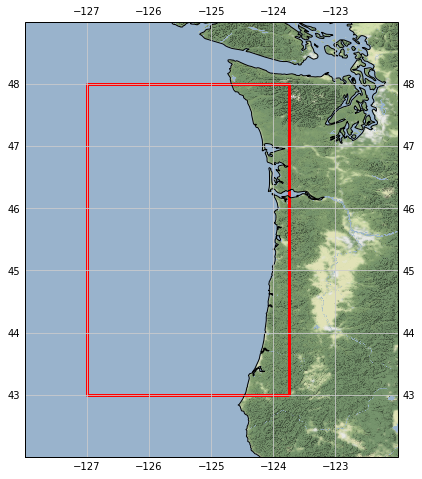

In [4]:
fig, ax = plt.subplots(1, figsize=(8, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent((-128, -122, 42, 49))

ax.add_image(StamenTerrain(), 8)
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True, color='0.8')

endurance_bbox_gs.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=3);

## First step: create the filter

In [5]:
from owslib import fes

(a) Bounding box: everything inside the dashed lines from the map above

In [6]:
bbox = [min_lon, min_lat, max_lon, max_lat]
crs = 'urn:ogc:def:crs:OGC:1.3:CRS84'

bbox_crs = fes.BBox(bbox, crs=crs)

(b) Time span: today - 5 days.

In [7]:
from datetime import datetime, timedelta
from ioos_tools.ioos import fes_date_filter


days = 20

now_datetime_utc = datetime.utcnow()
start = now_datetime_utc - timedelta(days=days)
stop = now_datetime_utc

begin, end = fes_date_filter(start, stop)

/home/mayorga/miniconda/envs/ioosaccess/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


(c) Variable: `sea_water_temperature`.

(All names in `name_list` are [CF standard names](http://cfconventions.org/standard-names.html),
but we can uses non-CF like 'Water Temperature' and that will return more datasets.)

In [8]:
sos_name = 'sea_water_temperature'

# NOTE: I added 'Water Temperature' to test for including NDBC endpoints
# Remove some of the modeling-oriented cf names?
cf_names = [
    'sea_water_temperature',
    'sea_surface_temperature',
    'sea_water_potential_temperature',
    'equivalent_potential_temperature',
    'sea_water_conservative_temperature',
    'pseudo_equivalent_potential_temperature',
]

# test to try to yield NDBC results
# cf_names = ['temp', 'sea_water_temperature']
# cf_names = ['stonewall', 'elizabeth']


kw = dict(
    wildCard='*',
    escapeChar='\\',
    singleChar='?',
    propertyname='apiso:AnyText'
)

or_filt = fes.Or(
    [fes.PropertyIsLike(literal=('*%s*' % val), **kw)
        for val in cf_names])

Assemble the `fes` filter with `a`+`b`+`c`.

In [9]:
vars(bbox_crs)

{'bbox': [-127, 43, -123.75, 48], 'crs': 'urn:ogc:def:crs:OGC:1.3:CRS84'}

In [10]:
vars(begin), vars(end)

({'propertyoperator': 'ogc:PropertyIsLessThanOrEqualTo',
  'propertyname': 'apiso:TempExtent_begin',
  'literal': '2018-08-20 06:00',
  'matchcase': True},
 {'propertyoperator': 'ogc:PropertyIsGreaterThanOrEqualTo',
  'propertyname': 'apiso:TempExtent_end',
  'literal': '2018-07-31 06:00',
  'matchcase': True})

In [11]:
filter_list = [
    fes.And(
        [
            bbox_crs,
            begin, end,
            or_filt,
            fes.Not([fes.PropertyIsLike(literal='*cdip*', **kw)]),
            fes.Not([fes.PropertyIsLike(literal='*grib*', **kw)]),
        ]
    )
]

In [12]:
from owslib.csw import CatalogueServiceWeb
from ioos_tools.ioos import get_csw_records


endpoint = 'https://data.ioos.us/csw'

csw = CatalogueServiceWeb(endpoint, timeout=60)

# get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)
get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)  # esn='full'

records = '\n'.join(csw.records.keys())
print('Found {} records.\n'.format(len(csw.records.keys())))

Found 28 records.



All the records found:

In [13]:
for key, value in list(csw.records.items()):
    print(u'[{}]\n  {}'.format(value.title, key))

[urn:ioos:station:NOAA.NOS.CO-OPS:9432780 station, Charleston, OR]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9432780
[urn:ioos:station:NOAA.NOS.CO-OPS:9435380 station, South Beach, OR]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9435380
[urn:ioos:station:NOAA.NOS.CO-OPS:9437540 station, Garibaldi, OR]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9437540
[urn:ioos:station:NOAA.NOS.CO-OPS:9439040 station, Astoria, OR]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9439040
[urn:ioos:station:NOAA.NOS.CO-OPS:9440581 station, Cape Disappointment]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9440581
[urn:ioos:station:NOAA.NOS.CO-OPS:9440910 station, Toke Point, WA]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9440910
[urn:ioos:station:NOAA.NOS.CO-OPS:9441102 station, Westport, WA]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9441102
[urn:ioos:station:NOAA.NOS.CO-OPS:

### Explore what a catalog metadata record looks like
Pick one result and explore it a bit.

In [14]:
asset_id = 'opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9437540'
# asset_id = 'sdf.ndbc.noaa.gov-urn_ioos_station_wmo_46050'

cswrec1 = csw.records[asset_id]

In [15]:
# pretty print xml
import xml.dom.minidom

cswrec1_parsedxml = xml.dom.minidom.parseString(cswrec1.xml)
print(cswrec1_parsedxml.toprettyxml(indent='    '))

<?xml version="1.0" ?>
<csw:SummaryRecord xmlns:csw="http://www.opengis.net/cat/csw/2.0.2" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:dct="http://purl.org/dc/terms/" xmlns:gmd="http://www.isotc211.org/2005/gmd" xmlns:gml="http://www.opengis.net/gml" xmlns:ows="http://www.opengis.net/ows" xmlns:xs="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
    <dc:identifier>opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9437540</dc:identifier>
    <dc:title>urn:ioos:station:NOAA.NOS.CO-OPS:9437540 station, Garibaldi, OR</dc:title>
    <dc:type>dataset</dc:type>
    <dc:subject>Air Temperature</dc:subject>
    <dc:subject>Barometric Pressure</dc:subject>
    <dc:subject>Conductivity</dc:subject>
    <dc:subject>Currents</dc:subject>
    <dc:subject>Datum</dc:subject>
    <dc:subject>Harmonic Constituents</dc:subject>
    <dc:subject>Rain Fall</dc:subject>
    <dc:subject>Relative Humidity</dc:subject>
    <dc:subject>Salinity</dc:subjec

### Detecting and inferring types of data service end point

First refer to the `dct:references@scheme` elements in the example above, and in the records in general. Then say briefly what `geolinks.sniff_links` does and why it's useful. 

We can use `geolinks.sniff_link`  to find more information about the services available.

In [16]:
len(cswrec1.references), cswrec1.references[:3]

(9,
 [{'scheme': 'OGC:SOS:DescribeSensor',
   'url': 'https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=DescribeSensor&outputFormat=text/xml; subtype="sensorML/1.0.1/profiles/ioos_sos/1.0"&version=1.0.0&procedure=urn:ioos:station:NOAA.NOS.CO-OPS:9437540'},
  {'scheme': 'WWW:LINK - text/csv',
   'url': 'http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?responseFormat=text/csv&eventTime=2018-08-04T12:21:08/2018-08-04T14:21:08&service=SOS&request=GetObservation&observedProperty=http://mmisw.org/ont/cf/parameter/air_pressure&offering=urn:ioos:station:NOAA.NOS.CO-OPS:9437540&version=1.0.0'},
  {'scheme': 'WWW:LINK - text/csv',
   'url': 'http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?responseFormat=text/csv&eventTime=2018-08-04T12:21:08/2018-08-04T14:21:08&service=SOS&request=GetObservation&observedProperty=http://mmisw.org/ont/cf/parameter/sea_surface_height_amplitude_due_to_equilibrium_ocean_tide&offering=urn:ioos:station:NOAA.NOS.CO-OPS:9437540&version=1.0.0

In [17]:
from geolinks import sniff_link


df = []
for key, rec in csw.records.items():
    df.append(pd.DataFrame(rec.references))

df = pd.concat(df, ignore_index=True)
df['geolink'] = [sniff_link(url) for url in df['url']]

However, we can also "hack" all the SOS URLs returned to get only those with the variable of interest, format, and `GetObservation` to download the data. We only need to correct the dates on the URLs b/c the `csw` ones are for 1-day only.

In [18]:
df.groupby(['geolink', 'scheme']).size()

geolink          scheme                     
OGC:SOS          OGC:SOS                         21
                 OGC:SOS:DescribeSensor          21
                 WWW:LINK - application/json    113
                 WWW:LINK - text/csv             53
                 WWW:LINK - text/xml            113
OGC:WCS          OGC:WCS                          4
OGC:WMS                                           2
                 OGC:WMS                          4
OPeNDAP:OPeNDAP                                   1
                 OPeNDAP:OPeNDAP                  1
                 WWW:LINK                         5
UNIDATA:NCSS     UNIDATA:NCSS                     4
WWW:LINK         WWW:LINK                         4
                 http                             2
dtype: int64

In [19]:
df.loc[df['scheme'] == 'OGC:SOS', 'url'].value_counts()

http://data.nanoos.org/52nsos/sos/kvp?acceptVersions=1.0.0&request=GetCapabilities&service=SOS                  13
http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=GetCapabilities&acceptVersions=1.0.0     8
Name: url, dtype: int64

### Now get observations time series data and crate plots and maps

We can get the canonical URL for SOS.

In [20]:
def fix_series(url, start, stop):
    split = url.split('&')
    new_url = []
    for line in split:
        if line.startswith('eventTime='):
            line = f'eventTime={start:%Y-%m-%dT%H:%m:00}/{stop:%Y-%m-%dT%H:%m:00}'
        new_url.append(line)

    return '&'.join(new_url)

In [21]:
sos_urls = [
    fix_series(url, start, stop) for url in df.loc[df['geolink'] == 'OGC:SOS', 'url']
    if 'GetObservation' in url 
    and 'text/csv' in url 
    and sos_name in url
]

len(sos_urls)

7

**Try to add the asset_id to the observations list, somewhere; or change from a list to a dict?** asset_id can then be used to retain and display the provider origin of the station time series. And/or the `scheme` OGC:SOS url's (all GetCapabilities); pull out their domain names.

In [22]:
observations = []
for url in sos_urls:
    observations.append(
        pd.read_csv(url, index_col='date_time', parse_dates=True)
    )

**Add code that goes over SOS GetObservation links to extract url's, extract unique response formats, find the IOOS SOS profile, then use those and pyoos to query for data from IOOS SOS profile requests. This will be all NANOOS SOS, I think.**

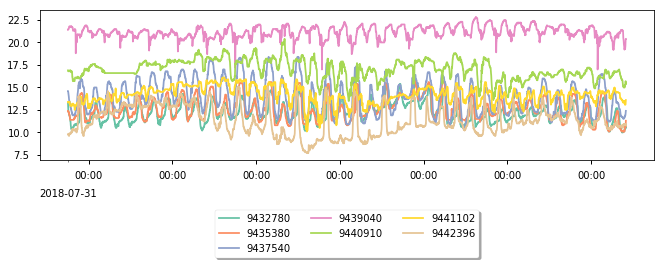

In [23]:
from itertools import cycle


def mpl_palette(cmap, n_colors=6):
    brewer_qual_pals = {"Accent": 8, "Dark2": 8, "Paired": 12,
                        "Pastel1": 9, "Pastel2": 8,
                        "Set1": 9, "Set2": 8, "Set3": 12}

    if cmap.name in brewer_qual_pals:
        bins = np.linspace(0, 1, brewer_qual_pals[cmap.name])[:n_colors]
    else:
        bins = np.linspace(0, 1, n_colors + 2)[1:-1]
    palette = list(map(tuple, cmap(bins)[:, :3]))

    pal_cycle = cycle(palette)
    palette = [next(pal_cycle) for _ in range(n_colors)]
    
    return palette

with mpl.style.context('seaborn-notebook'):
    fig, ax = plt.subplots(figsize=(11, 2.75))
    colors = mpl_palette(plt.cm.Set2, n_colors=len(observations))
    for k, series in enumerate(observations):
        station_name = series['station_id'].iloc[0].split(':')[-1]
        ax.plot(series.index, series['sea_water_temperature (C)'], label=station_name, color=colors[k])
    leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
              ncol=3, fancybox=True, shadow=True)

hours = mpl.dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(hours)

days = mpl.dates.DateFormatter('\n\n%Y-%m-%d')
ax.xaxis.set_minor_formatter(days)
ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator([mpl.dates.date2num(start)]))

## Map the sites, with pop-ups that include corresponding time series plots

In [24]:
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html


def make_marker(series):
    width, height = 500, 250

    # station = series['station_id'].iloc[0].split(':')[-1]
    station = series['station_id'].iloc[0]
    lat = series['latitude (degree)'].iloc[0]
    lon = series['longitude (degree)'].iloc[0]

    p = figure(
        x_axis_type='datetime',
        title=station,
        width=width, height=height)
    p.line(series.index, series['sea_water_temperature (C)'], line_width=2)
    html = file_html(p, CDN, station)
    iframe = IFrame(html, width=width+40, height=height+80)
    
    popup = folium.Popup(iframe, max_width=2650)
    icon = folium.Icon(color='green', icon='stats')
    marker = folium.Marker(
        location=[lat, lon],
        popup=popup,
        icon=icon
    )
    return marker

### Initialize the Folium map, then add elements to it
Markers, a box polygon (the bounding box), and OOI glider lines.

In [25]:
tiles = 'http://services.arcgisonline.com/arcgis/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}'

m = folium.Map(tiles=tiles, attr='ESRI')

In [26]:
for series in observations:
    make_marker(series).add_to(m)

Add the Endurance Array bounding box, then generate the Folium map.

In [27]:
# Look into adding a popup?
folium.GeoJson(endurance_bbox_shp.__geo_interface__,
              style_function=lambda feature: {'color': 'red', 'fillOpacity': 0.0}
              ).add_to(m)

m.fit_bounds(m.get_bounds())

m